In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# zscore
from scipy.stats import zscore
# scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import *
# partitioning
from sklearn.model_selection import train_test_split
# naive bayes
from sklearn.naive_bayes import GaussianNB, CategoricalNB
# plot things
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

In [2]:
df = pd.read_csv("ravdess_features.csv")

## Classification

### Choice of attributes

Each of us select a classification method and then select two variables, one to be classified by ourselves and one to be compared with the other methods, as clustering.
Classification methods:

* Naive Bayes - Claudio
* kNN - Andrea
* Decision trees - Steffania

Possible variables:

* Categorical: emotion, sex
* Numerical: intensity

We select these variables because they seems to us the most interesting variables to predict.

## Partitioning

In [3]:
def partition_df(df, attribute):
    tmp = df.copy()
    ret = {}
    partitions = tmp[attribute].unique()
    for p in partitions:
        ret[p] = df[(tmp[attribute] == p)]
                
    return ret

In [4]:
attr_part1 = "statement"
val1 = "Kids are talking by the door"

attr_part2 = "emotional_intensity"
val2 = "strong"

kids_strong = partition_df(df, attr_part1)[val1]
kids_strong = partition_df(kids_strong, attr_part2)[val2]
kids_strong = kids_strong.drop(columns = ["modality", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "channels", "frame_width"]).dropna()
kids_strong.T

,13,16,17,18,22,29,35,36,38,43,...,2394,2395,2400,2416,2417,2428,2433,2436,2441,2442
emotion,calm,calm,fearful,angry,fearful,surprised,angry,fearful,fearful,calm,...,sad,happy,happy,fearful,angry,surprised,happy,happy,sad,sad
sex,F,F,F,F,F,F,F,F,F,F,...,M,M,M,M,M,M,M,M,M,M
sample_width,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
frame_rate,48000,48000,48000,48000,48000,48000,48000,48000,48000,48000,...,48000,48000,48000,48000,48000,48000,48000,48000,48000,48000
length_ms,4504,3971,3737,3904,3637,3837,4504,4137,4204,5072,...,3837,4104,4404,4838,4705,4137,4438,4271,5305,4872
frame_count,216216.0,190590.0,179379.0,187388.0,174575.0,184184.0,216216.0,198598.0,201802.0,243444.0,...,184184.0,196997.0,211411.0,232232.0,225826.0,198599.0,213013.0,205005.0,254655.0,233834.0
intensity,-54.745974,-47.831966,-22.367588,-27.461209,-30.41386,-38.874822,-25.45817,-24.611364,-27.56825,-34.877249,...,-43.539869,-25.169836,-24.914071,-32.312589,-22.87656,-43.460545,-36.522822,-36.775127,-26.666414,-29.512788
zero_crossings_sum,13640,10575,21222,14749,16499,11703,20627,10885,17072,15835,...,11784,12562,17297,11755,12045,15672,12406,9012,11755,11043
mfcc_mean,-34.821735,-33.729385,-23.537529,-25.791014,-29.584751,-26.574883,-27.111847,-25.024746,-26.808258,-32.60896,...,-27.968382,-20.612392,-23.402376,-25.352774,-20.767807,-29.170189,-27.190395,-28.4094,-20.926167,-22.787794
mfcc_std,164.23001,160.28496,97.46727,111.2614,118.09067,135.42455,104.44275,103.02069,108.51158,132.7379,...,145.11029,104.25493,103.17724,124.38997,104.40976,145.77412,136.4705,136.80605,112.79364,113.3493


In [5]:
y = np.array(kids_strong["emotion"]) # <--- this is the variable prediction parameter
categorical_cols = ["emotion", "sex"]
kids_strong = pd.get_dummies(kids_strong, columns=categorical_cols)
X = kids_strong.values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

In [6]:
# without stratify
print(np.unique(y, return_counts=True)[1] / len(y))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))

[0.15343915 0.15608466 0.0978836  0.17195767 0.15608466 0.17195767
 0.09259259]
[0.15151515 0.14772727 0.08333333 0.18181818 0.17045455 0.17424242
 0.09090909]
[0.15789474 0.1754386  0.13157895 0.14912281 0.12280702 0.16666667
 0.09649123]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

In [8]:
# with stratify
print(np.unique(y, return_counts=True)[1] / len(y))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))

[0.15343915 0.15608466 0.0978836  0.17195767 0.15608466 0.17195767
 0.09259259]
[0.15530303 0.15530303 0.09848485 0.17045455 0.15530303 0.17045455
 0.09469697]
[0.14912281 0.15789474 0.09649123 0.1754386  0.15789474 0.1754386
 0.0877193 ]


In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(264, 37) (114, 37) (264,) (114,)


### Naive Bayes

In [10]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.57      0.76      0.65        17
        calm       1.00      0.61      0.76        18
     disgust       0.73      0.73      0.73        11
     fearful       0.71      0.25      0.37        20
       happy       0.35      0.61      0.45        18
         sad       0.69      0.55      0.61        20
   surprised       0.53      0.80      0.64        10

    accuracy                           0.59       114
   macro avg       0.65      0.62      0.60       114
weighted avg       0.66      0.59      0.59       114



Low reliability of the model for the _emotion_ prediction.

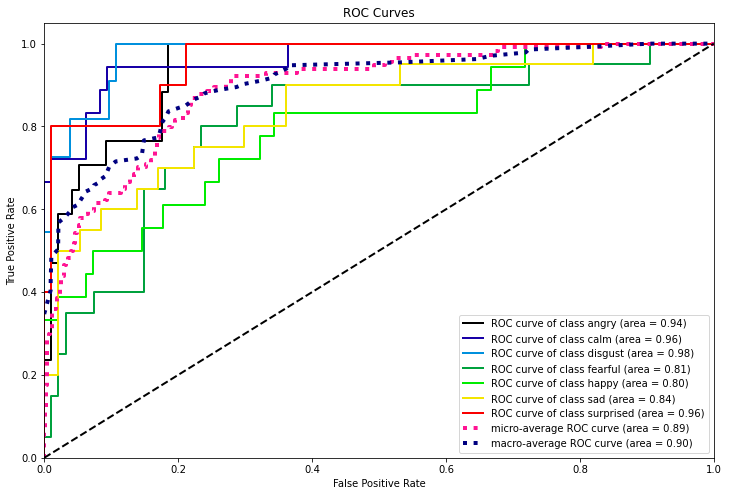

ROC AUC score:  0.8976020864261999


In [11]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plt.rcParams["figure.figsize"] = [12, 8]
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print("ROC AUC score: ", roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr", average="macro"))

#### Categorical

In [12]:
non_cat_columns = [ # commented variables contain redundant values that prevent NB from working properly
    "intensity",
    "zero_crossings_sum",
    "length_ms",
    "frame_count",
    #"sample_width",
    #"frame_rate",
    "mfcc_mean",
    "mfcc_min",
    "mfcc_max",
    "mfcc_std",
    "sc_mean",
    #"sc_min",
    "sc_max",
    "sc_std",
    "sc_kur",
    "sc_skew",
    "stft_mean",
    #"stft_min",
    #"stft_max",
    "stft_std",
    "stft_kur",
    "stft_skew",
    "mean",
    "std",
    "min",
    "max",
    "skew",
    "kur"
]

X_noncat = kids_strong[non_cat_columns].values

X_train_noncat, X_test_noncat, y_train_noncat, y_test_noncat = train_test_split(
    X_noncat, y, test_size=0.3, stratify=y, random_state=0
)

# train and test set should be binned separately
X_train_cat = list()
for column_idx in range(X_train_noncat.shape[1]):
    X_train_cat.append(pd.qcut(X_train_noncat[:, column_idx], q=4, labels=False))
X_train_cat = np.array(X_train_cat).T

X_test_cat = list()
for column_idx in range(X_test_noncat.shape[1]):
    X_test_cat.append(pd.qcut(X_test_noncat[:, column_idx], q=4, labels=False))
X_test_cat = np.array(X_test_cat).T

print(X_train_cat.shape, X_test_cat.shape)

(264, 23) (114, 23)


In [13]:
clf = CategoricalNB()
clf.fit(X_train_cat, y_train_noncat)
y_pred = clf.predict(X_test_cat)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.50      0.82      0.62        17
        calm       0.56      0.83      0.67        18
     disgust       0.75      0.55      0.63        11
     fearful       0.38      0.25      0.30        20
       happy       0.33      0.28      0.30        18
         sad       0.64      0.35      0.45        20
   surprised       0.58      0.70      0.64        10

    accuracy                           0.52       114
   macro avg       0.53      0.54      0.52       114
weighted avg       0.52      0.52      0.50       114



Very low reliability as regards the prediction of _emotion_ on the Categorical.

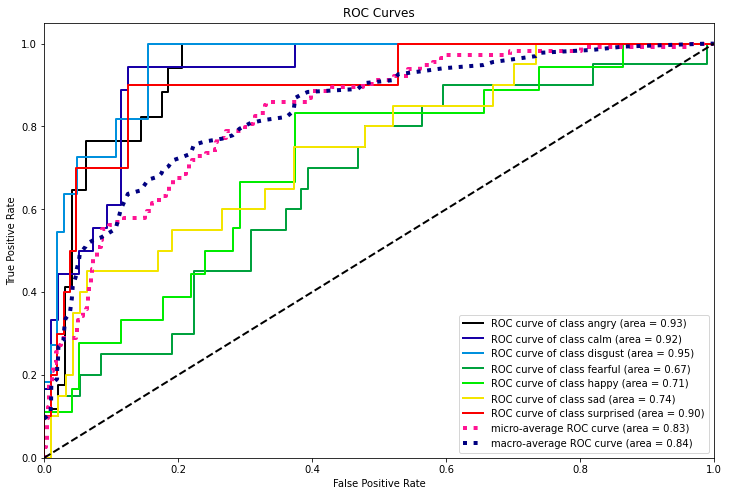

ROC AUC score:  0.8329313496025134


In [14]:
plt.rcParams["figure.figsize"] = [12, 8]
plot_roc(y_test_noncat, clf.predict_proba(X_test_cat))
plt.show()
print("ROC AUC score: ", roc_auc_score(y_test_noncat, clf.predict_proba(X_test_cat), multi_class="ovr", average="macro"))

The score of categorical test is lower than non categorical one.